# This is a sample Jupyter Notebook

Below is an example of a code cell. 
Put your cursor into the cell and press Shift+Enter to execute it and select the next one, or click 'Run Cell' button.

Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.

To learn more about Jupyter Notebooks in PyCharm, see [help](https://www.jetbrains.com/help/pycharm/ipython-notebook-support.html).
For an overview of PyCharm, go to Help -> Learn IDE features or refer to [our documentation](https://www.jetbrains.com/help/pycharm/getting-started.html).

In [632]:
import sys
print(sys.executable)

C:\Users\bened\miniconda3\envs\DSHF3\python.exe


In [633]:
# Szükséges könyvtárak importálása
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from scipy import stats
from datetime import datetime
import glob

warnings.filterwarnings('ignore')

# Ábrázolási beállítások
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("Könyvtárak importálva!")


Könyvtárak importálva!


In [634]:
# Könyvtárak elérési útjai
data_path = Path('data/usa_stocks_data')
constituents_path = data_path / 'index/constituents'
idxperf_path = data_path / 'index/perf'
stock_prices_path = data_path / 'stock_prices'

# Index részvényeinek betöltése
sp500_companies1 = pd.read_csv(constituents_path / 'sp500.csv', header=0, index_col=0)
sp500_companies2 = pd.read_csv(constituents_path / 'sp500_companies.csv', header=0, index_col=0)
dowjones_companies = pd.read_csv(constituents_path / 'dowjones_companies.csv', header=0, index_col=0)
nasdaq100_companies = pd.read_csv(constituents_path / 'nasdaq100_companies.csv', header=0, index_col=0)

# Index teljesítmény adatok betöltése
sp500_perf = pd.read_csv(idxperf_path / 'SP500_perf.csv', parse_dates=['Date'], header=0, index_col=0)
dowjones_perf = pd.read_csv(idxperf_path / 'Dow_Jones_perf.csv', parse_dates=['Date'], header=0, index_col=0)
nasdaq100_perf = pd.read_csv(idxperf_path / 'Nasdaq100_perf.csv', parse_dates=['Date'], header=0, index_col=0)

print("Indexek betöltve!")

Indexek betöltve!


## S&P 500

Amint látható, S&P 500 indexhez 2 fájl is található. Ezeket megvizsgálom, és a jelenlegi állapotához közelebbit használom a továbbiakban

In [635]:
# Szimbólumok összehasonlítása
print(f"sp500_companies.csv rekordjainak száma: {len(sp500_companies1)}")
print(f"sp500.csv rekordjainak száma: {len(sp500_companies2)}")

sp500_symbols = set(sp500_companies1['Symbol'].unique())
sp500_companies_symbols = set(sp500_companies2['Symbol'].unique())

print(f"\nSP500.csv egyedi szimbólumok száma: {len(sp500_symbols)}")
print(f"SP500_companies.csv egyedi szimbólumok száma: {len(sp500_companies_symbols)}")

# Szimbólumok, amelyek csak az egyikben vannak
only_sp500 = sp500_symbols - sp500_companies_symbols
only_sp500_companies = sp500_companies_symbols - sp500_symbols
common_symbols = sp500_symbols & sp500_companies_symbols

print(f"\nKözös szimbólumok: {len(common_symbols)}")
print(f"Csak SP500-ban lévő szimbólumokszáma: {len(only_sp500)}")
print(f"Csak SP500_companies-ben lévő szimbólumok száma: {len(only_sp500_companies)}")

print(f"\nCsak SP500-ban lévő szimbólumok: {list(only_sp500)}")
print(f"Csak SP500_companies-ben lévő szimbólumok: {list(only_sp500_companies)}")


sp500_companies.csv rekordjainak száma: 503
sp500.csv rekordjainak száma: 501

SP500.csv egyedi szimbólumok száma: 503
SP500_companies.csv egyedi szimbólumok száma: 501

Közös szimbólumok: 500
Csak SP500-ban lévő szimbólumokszáma: 3
Csak SP500_companies-ben lévő szimbólumok száma: 1

Csak SP500-ban lévő szimbólumok: ['ABNB', 'VLTO', 'BX']
Csak SP500_companies-ben lévő szimbólumok: ['NWL']


Azt, hogy nem 500 rekordot tartalmaznak a fájlok az magyarázza, hogy bizonyos cégeknek több osztályú részvénye is része a rekordoknak, pl.: GOOG (Class B), GOOGL (Class A)

In [636]:
#Attribútumok vizsgálata
print(f"\nsp500.csv oszlopok:\n {list(sp500_companies1.columns)}\n")
print(f"\nsp500_companies.csv oszlopok:\n {list(sp500_companies2.columns)}\n")


sp500.csv oszlopok:
 ['Symbol', 'Security', 'GICS Sector', 'GICS Sub-Industry', 'Headquarters Location', 'Date added', 'CIK', 'Founded', 'Shares Outstanding']


sp500_companies.csv oszlopok:
 ['Symbol', 'Company Name', 'Industry', 'Sector', 'Founded', 'shares outstanding']



A rekordok számának viszgálatából kiderült, hogy egyik fájlban sincs duplikált adat.

Az sp500_companies.csv-ben található egyedül az NWL (Newell Brands Inc.), ami 2023 szeptember 18.-án kikerült az indexből.
Az sp500.csv-ben található egyedül 'ABNB', 'VLTO', 'BX', (Airbnb, Inc., Blackstone Inc., Veralto Corp.), amik 2023 szeptember 18.-án, és 2023 október 2.-án kerültek fel az indexre.
Ezek alapján az sp500.csv aktuálisabb információt tartalmaz.

Emellet az sp500.csv több információt tartalmaz a cégekről, és összes sp500_companies.csv-ben találhtó attribútum is jelen van.

# Tehát innentől az sp500.csv-t használom az S&P 500 teljesítményének vizsgálatára.


In [637]:
sp500 = sp500_companies1

Adatok tisztítása

In [638]:
text_cols = ['Symbol', 'Security', 'GICS Sector', 'GICS Sub-Industry', 'Headquarters Location']
for col in text_cols:
    sp500[col] = sp500[col].astype('string').str.strip()

sp500['Date added'] = pd.to_datetime(sp500['Date added'], errors='coerce')

sp500['CIK'] = sp500['CIK'].astype(str).str.zfill(10)

import re
def extract_year(x):
    if pd.isna(x):
        return pd.NA
    years = [int(y) for y in re.findall(r'(\d{4})', str(x))]
    return min(years) if years else pd.NA

sp500['Founded'] = sp500['Founded'].apply(extract_year)
sp500['Founded'] = pd.to_numeric(sp500['Founded'], errors='coerce')



print(sp500.isna().sum())
print(sp500[sp500["Founded"].isna()].Symbol)
print(sp500[sp500["Date added"].isna()].Symbol)
sp500.head()


Symbol                    0
Security                  0
GICS Sector               0
GICS Sub-Industry         1
Headquarters Location     0
Date added               12
CIK                       0
Founded                   0
Shares Outstanding        0
dtype: int64
Series([], Name: Symbol, dtype: string)
156       D
186      ES
211     FCX
243     HUM
404     ROK
415     SRE
435    TROW
445     TXN
457     USB
482      WM
490      WY
491     WHR
Name: Symbol, dtype: string


,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded,Shares Outstanding
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,0000066740,1902,5.519920e+08
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,0000091142,1916,1.504910e+08
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,0000001800,1888,1.735360e+09
3,ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,0001551152,1888,1.765050e+09
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,0001467373,1989,6.295080e+08


 Attribútumok vizsgálata

In [639]:
sp500.info()

<class 'pandas.core.frame.DataFrame'>
Index: 503 entries, 0 to 502
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Symbol                 503 non-null    string        
 1   Security               503 non-null    string        
 2   GICS Sector            503 non-null    string        
 3   GICS Sub-Industry      502 non-null    string        
 4   Headquarters Location  503 non-null    string        
 5   Date added             491 non-null    datetime64[ns]
 6   CIK                    503 non-null    object        
 7   Founded                503 non-null    int64         
 8   Shares Outstanding     503 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1), string(5)
memory usage: 39.3+ KB


Hiányzó adatok vizsgálata

In [640]:
print(sp500[sp500["GICS Sub-Industry"].isna()])

    Symbol Security  GICS Sector GICS Sub-Industry   Headquarters Location  \
468   VLTO  Veralto  Industrials              <NA>  Waltham, Massachusetts   

    Date added         CIK  Founded  Shares Outstanding  
468 2023-10-02  0001967680     2023         246291005.0  


Hiányzó adat: Environmental & Facilities Services, ennek hozzáadása

In [641]:
sp500.loc[sp500["Symbol"] == "VLTO", "GICS Sub-Industry"] = "Environmental & Facilities Services"

In [642]:
print(sp500[sp500["Date added"].isna()].Symbol)

156       D
186      ES
211     FCX
243     HUM
404     ROK
415     SRE
435    TROW
445     TXN
457     USB
482      WM
490      WY
491     WHR
Name: Symbol, dtype: string


In [643]:
missing_map = {
    "D":   "2016-11-30",
    "ES":  "2009-07-24",
    "FCX": "2011-07-01",
    "HUM": "2012-12-10",
    "ROK": "2000-03-12",
    "SRE": "2017-03-17",
    "TROW":"2019-07-29",
    "TXN": "2001-03-12",
    "USB": "1999-11-01",
    "WM":  "1998-08-31",
    "WY":  "1979-10-01",
    "WHR": "1959-04-01",
}

for sym, date in missing_map.items():
    sp500.loc[(sp500["Symbol"] == sym) & (sp500["Date added"].isna()), "Date added"] = date

In [644]:
sp500.info()
sp500.head()

<class 'pandas.core.frame.DataFrame'>
Index: 503 entries, 0 to 502
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Symbol                 503 non-null    string        
 1   Security               503 non-null    string        
 2   GICS Sector            503 non-null    string        
 3   GICS Sub-Industry      503 non-null    string        
 4   Headquarters Location  503 non-null    string        
 5   Date added             503 non-null    datetime64[ns]
 6   CIK                    503 non-null    object        
 7   Founded                503 non-null    int64         
 8   Shares Outstanding     503 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1), string(5)
memory usage: 39.3+ KB


,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded,Shares Outstanding
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,0000066740,1902,5.519920e+08
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,0000091142,1916,1.504910e+08
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,0000001800,1888,1.735360e+09
3,ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,0001551152,1888,1.765050e+09
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,0001467373,1989,6.295080e+08


A hiányzó adatok ki lettek töltve.

In [645]:
sp500.info()

<class 'pandas.core.frame.DataFrame'>
Index: 503 entries, 0 to 502
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Symbol                 503 non-null    string        
 1   Security               503 non-null    string        
 2   GICS Sector            503 non-null    string        
 3   GICS Sub-Industry      503 non-null    string        
 4   Headquarters Location  503 non-null    string        
 5   Date added             503 non-null    datetime64[ns]
 6   CIK                    503 non-null    object        
 7   Founded                503 non-null    int64         
 8   Shares Outstanding     503 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1), string(5)
memory usage: 39.3+ KB


Az szektorok száma megegyezik a GICS által meghatározottnak, az iparágaké nem, mivel vannak olyanok amik nem elemei az indexnek.

In [646]:
sp500_perf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24060 entries, 1927-12-30 00:00:00-05:00 to 2023-10-11 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          24060 non-null  float64
 1   High          24060 non-null  float64
 2   Low           24060 non-null  float64
 3   Close         24060 non-null  float64
 4   Volume        24060 non-null  int64  
 5   Dividends     24060 non-null  float64
 6   Stock Splits  24060 non-null  float64
dtypes: float64(6), int64(1)
memory usage: 1.5+ MB


In [647]:
sp500_perf.index = pd.to_datetime(sp500_perf.index,utc=True, errors='coerce')
sp500_perf.index = sp500_perf.index.tz_convert("America/New_York")
sp500_perf.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24060 entries, 1927-12-30 00:00:00-05:00 to 2023-10-11 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          24060 non-null  float64
 1   High          24060 non-null  float64
 2   Low           24060 non-null  float64
 3   Close         24060 non-null  float64
 4   Volume        24060 non-null  int64  
 5   Dividends     24060 non-null  float64
 6   Stock Splits  24060 non-null  float64
dtypes: float64(6), int64(1)
memory usage: 1.5 MB


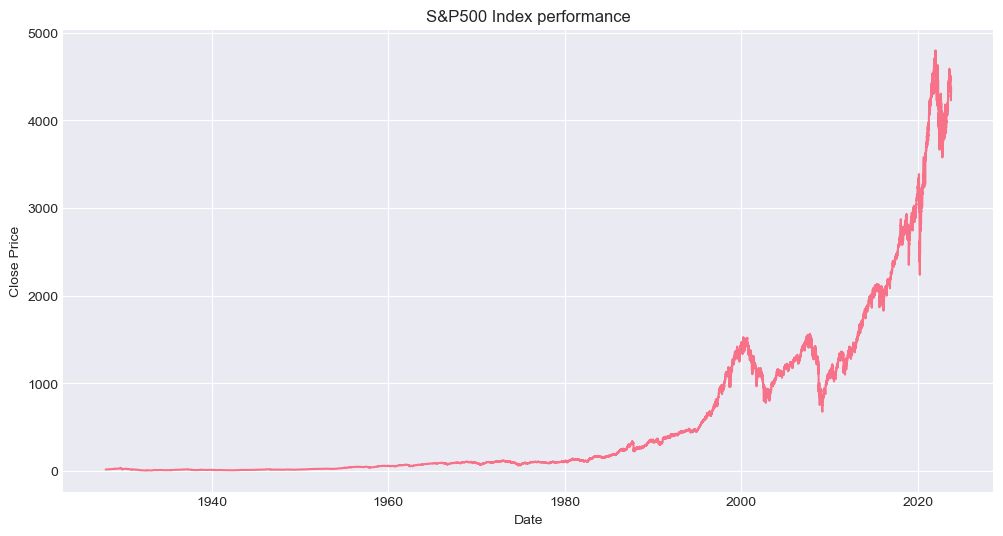

In [648]:
plt.plot(sp500_perf.index, sp500_perf["Close"])
plt.title("S&P500 Index performance")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()

# Nasdaq 100


In [649]:
nasdaq100_companies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 101 entries, 0 to 100
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Symbol              101 non-null    object 
 1   Company Name        101 non-null    object 
 2   Industry            101 non-null    object 
 3   Sector              101 non-null    object 
 4   Founded             101 non-null    object 
 5   shares outstanding  101 non-null    float64
dtypes: float64(1), object(5)
memory usage: 5.5+ KB


In [650]:
text_cols = ['Symbol', 'Company Name', 'Industry', 'Sector']
for col in text_cols:
    nasdaq100_companies[col] = nasdaq100_companies[col].astype('string').str.strip()

nasdaq100_companies['Founded'] = pd.to_numeric(nasdaq100_companies['Founded'], errors='coerce')


print(nasdaq100_companies.isna().sum())
print(nasdaq100_companies[nasdaq100_companies["Founded"].isna()].Symbol)



Symbol                 0
Company Name           0
Industry               0
Sector                 0
Founded               12
shares outstanding     0
dtype: int64
8     AVGO
24     HON
35    MDLZ
45     CSX
52    MNST
54      JD
66      ON
68    SGEN
69     EXC
75    IDXX
78     BKR
98    SIRI
Name: Symbol, dtype: string


In [651]:
missing_map = {
    "AVGO": 1961,
    "HON":  1885,
    "MDLZ": 1903,
    "CSX":  1980,
    "MNST": 1935,
    "JD":   1998,
    "ON":   1999,
    "SGEN": 1998,
    "EXC":  2000,
    "IDXX": 1983,
    "BKR":  1908,
    "SIRI": 2008
}

for sym, date in missing_map.items():
    nasdaq100_companies.loc[(nasdaq100_companies["Symbol"] == sym) & (nasdaq100_companies["Founded"].isna()), "Founded"] = date

nasdaq100_companies['Founded'] = nasdaq100_companies['Founded'].astype(int)

In [652]:
nasdaq100_companies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 101 entries, 0 to 100
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Symbol              101 non-null    string 
 1   Company Name        101 non-null    string 
 2   Industry            101 non-null    string 
 3   Sector              101 non-null    string 
 4   Founded             101 non-null    int64  
 5   shares outstanding  101 non-null    float64
dtypes: float64(1), int64(1), string(4)
memory usage: 5.5 KB


In [653]:
nasdaq100_perf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9585 entries, 1985-10-01 00:00:00-04:00 to 2023-10-11 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          9585 non-null   float64
 1   High          9585 non-null   float64
 2   Low           9585 non-null   float64
 3   Close         9585 non-null   float64
 4   Volume        9585 non-null   int64  
 5   Dividends     9585 non-null   float64
 6   Stock Splits  9585 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 599.1+ KB


In [654]:
nasdaq100_perf.index = pd.to_datetime(nasdaq100_perf.index,utc=True, errors='coerce')
nasdaq100_perf.index = nasdaq100_perf.index.tz_convert("America/New_York")

nasdaq100_perf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9585 entries, 1985-10-01 00:00:00-04:00 to 2023-10-11 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          9585 non-null   float64
 1   High          9585 non-null   float64
 2   Low           9585 non-null   float64
 3   Close         9585 non-null   float64
 4   Volume        9585 non-null   int64  
 5   Dividends     9585 non-null   float64
 6   Stock Splits  9585 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 599.1 KB


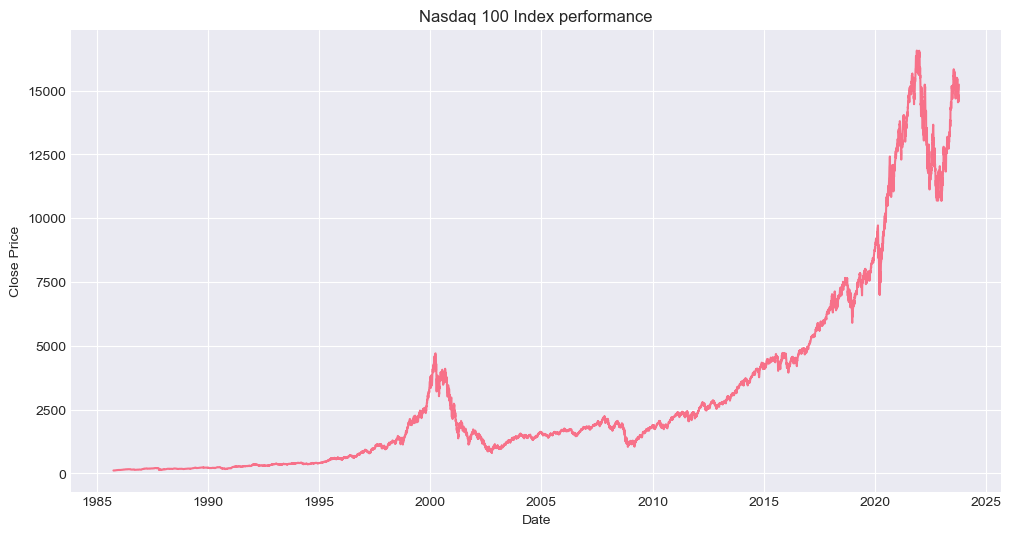

In [655]:
plt.plot(nasdaq100_perf.index, nasdaq100_perf["Close"])
plt.title("Nasdaq 100 Index performance")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()

# Dow Jones

In [656]:
dowjones_companies.info()
dowjones_companies.columns

<class 'pandas.core.frame.DataFrame'>
Index: 30 entries, 0 to 29
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Symbol        30 non-null     object
 1   Company Name  30 non-null     object
 2   Industry      30 non-null     object
 3   Sector        30 non-null     object
 4   Founded       30 non-null     object
dtypes: object(5)
memory usage: 1.4+ KB


Index(['Symbol', 'Company Name', 'Industry', 'Sector', 'Founded'], dtype='object')

In [657]:
text_cols = ['Symbol', 'Company Name', 'Industry', 'Sector']
for col in text_cols:
    dowjones_companies[col] = dowjones_companies[col].astype('string').str.strip()

dowjones_companies['Founded'] = pd.to_numeric(dowjones_companies['Founded'], errors='coerce')


print(dowjones_companies.isna().sum())
print(dowjones_companies[dowjones_companies["Founded"].isna()].Symbol)



Symbol          0
Company Name    0
Industry        0
Sector          0
Founded         2
dtype: int64
22    HON
28    DOW
Name: Symbol, dtype: string


In [658]:
missing_map = {
    "HON": 1906,
    "DOW":  1897
}

for sym, date in missing_map.items():
    dowjones_companies.loc[(dowjones_companies["Symbol"] == sym) & (dowjones_companies["Founded"].isna()), "Founded"] = date

dowjones_companies['Founded'] = dowjones_companies['Founded'].astype(int)

dowjones_companies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30 entries, 0 to 29
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Symbol        30 non-null     string
 1   Company Name  30 non-null     string
 2   Industry      30 non-null     string
 3   Sector        30 non-null     string
 4   Founded       30 non-null     int64 
dtypes: int64(1), string(4)
memory usage: 1.4 KB


In [659]:
dowjones_perf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8004 entries, 1992-01-02 00:00:00-05:00 to 2023-10-11 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          8004 non-null   float64
 1   High          8004 non-null   float64
 2   Low           8004 non-null   float64
 3   Close         8004 non-null   float64
 4   Volume        8004 non-null   int64  
 5   Dividends     8004 non-null   float64
 6   Stock Splits  8004 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 500.2+ KB


In [660]:
dowjones_perf.index = pd.to_datetime(dowjones_perf.index, utc=True, errors="coerce")
dowjones_perf.index = dowjones_perf.index.tz_convert("America/New_York")
dowjones_perf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8004 entries, 1992-01-02 00:00:00-05:00 to 2023-10-11 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          8004 non-null   float64
 1   High          8004 non-null   float64
 2   Low           8004 non-null   float64
 3   Close         8004 non-null   float64
 4   Volume        8004 non-null   int64  
 5   Dividends     8004 non-null   float64
 6   Stock Splits  8004 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 500.2 KB


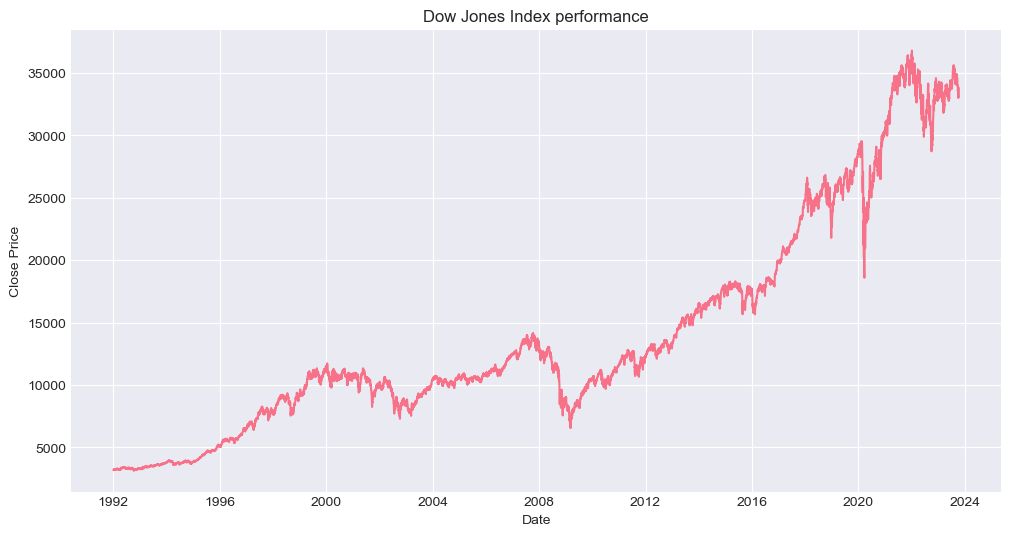

In [661]:
plt.plot(dowjones_perf.index, dowjones_perf["Close"])
plt.title("Dow Jones Index performance")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()

# Inflációs adatok

Adatok betöltése, újraformázása későbbi felhasználhatóság érdakében
Jelenleg 1 sor = 1 év 12 hónapra és azok átlaga
Ezeket átrendezem úgy, hogy 1 sorban legyen 1 hónap inflációs adata

In [662]:
inflation_temp = pd.read_csv('data/usa_stocks_data/usd_inflation.csv', parse_dates=['Year'], header=0)
inflation_temp.head()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Ave
0,1914-01-01,2.0,1.0,1.0,0.0,2.1,1.0,1.0,3.0,2.0,1.0,1.0,1.0,1.0
1,1915-01-01,1.0,1.0,0.0,2.0,2.0,2.0,1.0,-1.0,-1.0,1.0,1.0,2.0,1.0
2,1916-01-01,3.0,4.0,6.1,6.0,5.9,6.9,6.9,7.9,9.9,10.8,11.7,12.6,7.9
3,1917-01-01,12.5,15.4,14.3,18.9,19.6,20.4,18.5,19.3,19.8,19.5,17.4,18.1,17.4
4,1918-01-01,19.7,17.5,16.7,12.7,13.3,13.1,18.0,18.5,18.0,18.5,20.7,20.4,18.0


In [663]:
#adatok átrendezése
inflation = inflation_temp.melt(
    id_vars=["Year"],
    value_vars=["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"],
    var_name="Month",
    value_name="Inflation"
)
inflation["Year"] = pd.to_datetime(inflation["Year"]).dt.year
# dátum aggregálása egy attribútumba
inflation["Date"] = pd.to_datetime(inflation["Year"].astype(str) + "-" + inflation["Month"], format="%Y-%b")
inflation = inflation[["Date","Inflation"]].sort_values("Date").reset_index(drop=True)

# azon sorok elhagyása amikhez nincs inflációs adat (2023 vége)
inflation = inflation.dropna(subset=["Inflation"]).reset_index(drop=True)

inflation.info()
inflation.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1316 entries, 0 to 1315
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1316 non-null   datetime64[ns]
 1   Inflation  1316 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 20.7 KB


,Date,Inflation
0,1914-01-01,2.0
1,1914-02-01,1.0
2,1914-03-01,1.0
3,1914-04-01,0.0
4,1914-05-01,2.1


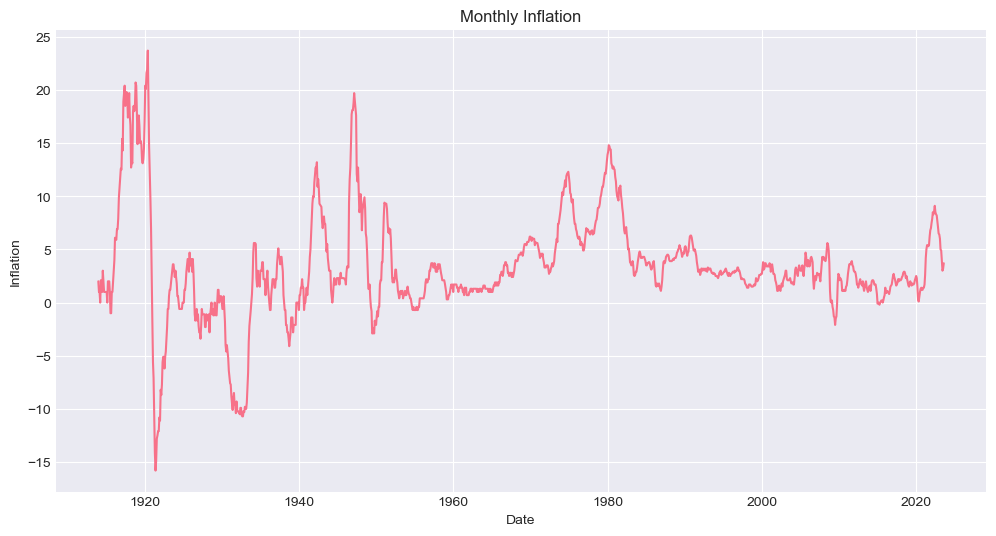

In [664]:
#plt.figure(figsize=(10,5))
plt.plot(inflation["Date"], inflation["Inflation"])
plt.title("Monthly Inflation")
plt.xlabel("Date")
plt.ylabel("Inflation")
plt.grid(True)
plt.show()

# Részvények betöltése

Struktúra vizsgálata

In [665]:
teststock = pd.read_csv('data/usa_stocks_data/stock_prices/AAPL.csv', header=0, index_col=0)
teststock.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10798 entries, 1980-12-12 00:00:00-05:00 to 2023-10-11 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          10798 non-null  float64
 1   High          10798 non-null  float64
 2   Low           10798 non-null  float64
 3   Close         10798 non-null  float64
 4   Volume        10798 non-null  int64  
 5   Dividends     10798 non-null  float64
 6   Stock Splits  10798 non-null  float64
dtypes: float64(6), int64(1)
memory usage: 674.9+ KB


In [666]:
teststock.index = pd.to_datetime(teststock.index, utc=True, errors="coerce")
teststock.index = teststock.index.tz_convert("America/New_York")
teststock.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10798 entries, 1980-12-12 00:00:00-05:00 to 2023-10-11 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          10798 non-null  float64
 1   High          10798 non-null  float64
 2   Low           10798 non-null  float64
 3   Close         10798 non-null  float64
 4   Volume        10798 non-null  int64  
 5   Dividends     10798 non-null  float64
 6   Stock Splits  10798 non-null  float64
dtypes: float64(6), int64(1)
memory usage: 674.9 KB


In [667]:
folder = Path("data/usa_stocks_data/stock_prices/")
prices = {}# dictionary approach
stocks = []

for csv_file in folder.glob("*.csv"):
    symbol = csv_file.stem  # filename without extension
    df = pd.read_csv(csv_file, header=0, index_col=0)

    df.index = pd.to_datetime(df.index, utc=True, errors="coerce")
    df.index = df.index.tz_convert("America/New_York")

    # Store in dictionary
    stocks.append(symbol)
    prices[symbol] = df

# Example access:
prices['AAPL'].head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1980-12-12 00:00:00-05:00,0.099450,0.099882,0.099450,0.099450,469033600,0.0,0.0
1980-12-15 00:00:00-05:00,0.094694,0.094694,0.094261,0.094261,175884800,0.0,0.0
1980-12-16 00:00:00-05:00,0.087775,0.087775,0.087343,0.087343,105728000,0.0,0.0
1980-12-17 00:00:00-05:00,0.089504,0.089937,0.089504,0.089504,86441600,0.0,0.0
1980-12-18 00:00:00-05:00,0.092099,0.092532,0.092099,0.092099,73449600,0.0,0.0


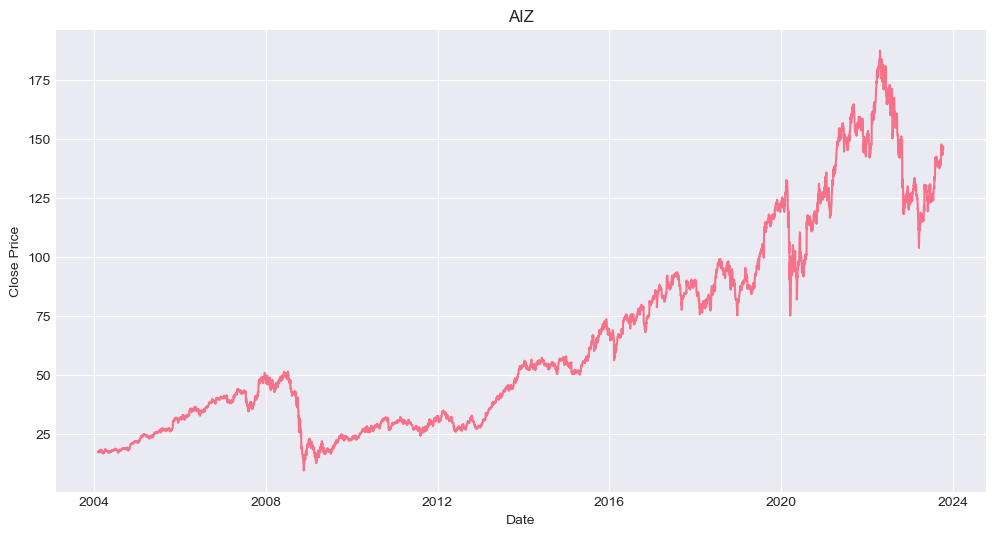

In [668]:
current_stock = stocks[18]
plt.plot(prices[current_stock].index, prices[current_stock]["Close"])
plt.title(current_stock)
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()
